#Reading result files and transforming them into a table

Processing experiment: AOI_lines-allTrialsFixIma-CNNhyperParams
T1_Syllables_10NN_without_scaler.csv: 0.6571 +/- 0.0535 (predicted classes: [0 1]; counts: [59 11])
T1_Syllables_10NN_with_scaler.csv: 0.5857 +/- 0.0286 (predicted classes: [0 1]; counts: [64  6])
T1_Syllables_1NN_without_scaler.csv: 0.7429 +/- 0.0571 (predicted classes: [0 1]; counts: [51 19])
T1_Syllables_1NN_with_scaler.csv: 0.6857 +/- 0.0728 (predicted classes: [0 1]; counts: [55 15])
T1_Syllables_3NN_without_scaler.csv: 0.7429 +/- 0.0571 (predicted classes: [0 1]; counts: [53 17])
T1_Syllables_3NN_with_scaler.csv: 0.6571 +/- 0.0833 (predicted classes: [0 1]; counts: [57 13])
T1_Syllables_4NN_without_scaler.csv: 0.6571 +/- 0.0535 (predicted classes: [0 1]; counts: [59 11])
T1_Syllables_4NN_with_scaler.csv: 0.5857 +/- 0.0286 (predicted classes: [0 1]; counts: [64  6])
T1_Syllables_5NN_without_scaler.csv: 0.6714 +/- 0.0571 (predicted classes: [0 1]; counts: [56 14])
T1_Syllables_5NN_with_scaler.csv: 0.6857 +/- 0.0350 (pr

c:\Users\xsedmid.NTFI\AppData\Local\Programs\Python\virtual_envs\venv-Python3.11\Lib\site-packages\IPython\core\events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
c:\Users\xsedmid.NTFI\AppData\Local\Programs\Python\virtual_envs\venv-Python3.11\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


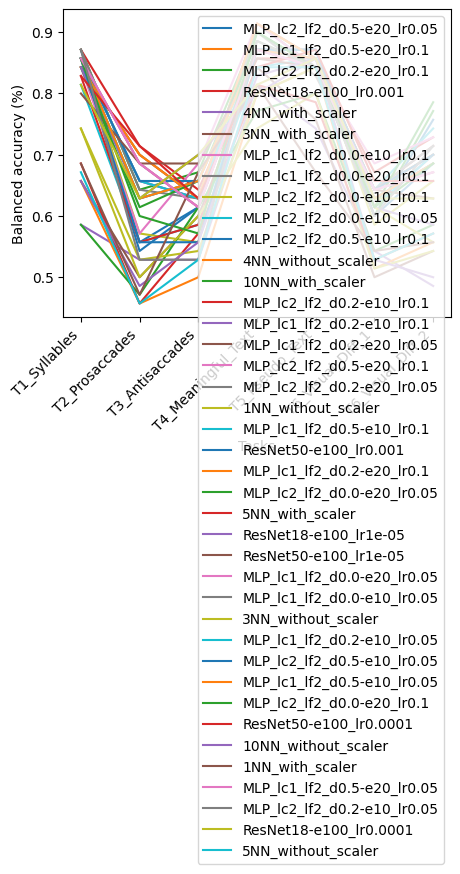

In [1]:
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from typing import Dict
import pandas as pd
import numpy as np
import os

training_param_cv_split_count = 5

task_definitions = [('T1', 'Syllables'), ('T2', 'Prosaccades'), ('T3', 'Antisaccades'), ('T4', 'Meaningful_Text'), ('T5', 'Pseudo_Text'), ('T6', 'Visual_Diff_1'), ('T6', 'Visual_Diff_2')]
data_version_dir = "v3.0"
DATA_FILE_EXT = '.csv'

out_results_dir = f"y:/trials/xsedmid/dyslex/experiment-final/{data_version_dir}/results/xxx/"

total_result_mean_dict: Dict = {}
total_result_std_dict: Dict = {}
total_approach_names = []
total_exp_names = []

for exp_name in os.listdir(out_results_dir):
    exp_dir_path = os.path.join(out_results_dir, exp_name)
    if os.path.isdir(exp_dir_path):
        print(f'Processing experiment: {exp_name}')

        plot_dict: Dict = {}
        approach_names = []
        for task_id, task_desc in task_definitions:
            task_file_prefix = task_id + '_' + task_desc + '_'

            results_files = os.listdir(exp_dir_path)
            results_files = list(filter(lambda f: f.lower().startswith(task_file_prefix.lower()) and f.lower().endswith(DATA_FILE_EXT.lower()), results_files))
            for result_file in results_files:

                # Get the approach name from the file name
                approach_name = result_file[len(task_file_prefix):-len(DATA_FILE_EXT)]
                approach_names.append(approach_name)

                df = pd.read_csv(os.path.join(exp_dir_path, result_file), skiprows=0, sep=',')

                # Convert column values to a numpy array
                targets = np.asarray(df['subject_class_id'].values)
                preds = np.asarray(df['pred_class_id'].values)
                
                # Compute the number of different values and their counts in targets and preds
                target_values, target_values_counts = np.unique(targets, return_counts=True)
                pred_values, pred_values_counts = np.unique(preds, return_counts=True)

                # Split targets and predictions into batches of a fixed size
                batch_size = targets.size / training_param_cv_split_count
                targets_batches = np.array_split(targets, len(targets) // batch_size)
                preds_batches = np.array_split(preds, len(preds) // batch_size)

                # Calculate the balanced accuracy score for each batch
                scores = []
                for i, (target_batch, pred_batch) in enumerate(zip(targets_batches, preds_batches)):
                    scores.append(balanced_accuracy_score(target_batch, pred_batch))
                # Print the mean and standard deviation of the balanced accuracy scores
                print(f'{result_file}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} (predicted classes: {pred_values}; counts: {pred_values_counts})')
                
                # Add the score to the plot dictionary
                plot_dict[(task_id + '_' + task_desc, approach_name)] = np.mean(scores)


                total_result_mean_dict[(exp_name, task_id + '_' + task_desc, approach_name)] = np.mean(scores)
                total_result_std_dict[(exp_name, task_id + '_' + task_desc, approach_name)] = np.std(scores)
        
        # Make the approach names unique
        approach_names = list(set(approach_names))

        total_exp_names.append(exp_name)
        total_approach_names.extend(approach_names)

        #df_plot = pd.DataFrame()
        fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')

        # Get numpy array from task ids
        task_ids_np = np.array([task_id + '_' + task_desc for task_id, task_desc in task_definitions])

        # Generate the plot for each approach
        for approach_name in approach_names:
            scores = []
            for task_id, task_desc in task_definitions:
                scores.append(plot_dict[(task_id + '_' + task_desc, approach_name)] if (task_id + '_' + task_desc, approach_name) in plot_dict else 0)
            #ax.scatter(task_ids_np, scores, s=100, alpha=0.5, label=approach_name)
            ax.plot(task_ids_np, scores, label=approach_name)

        # Rotate the x-axis labels
        plt.xticks(rotation=45, ha='right')

        ax.legend()
        ax.set_xlabel('Tasks')
        ax.set_ylabel('Balanced accuracy (%)')

print('************************* Total results *************************')
total_approach_names = list(set(total_approach_names))
for task_id, task_desc in task_definitions:
    print(f'************************* {task_id}_{task_desc} *************************')
    
    # Print names of all approaches separated by tabs
    print(f';{";;".join(total_approach_names)}')
    
    for exp_name in total_exp_names:
        scores_mean_std = []
        for approach_name in total_approach_names:
            scores_mean_std.append(str(total_result_mean_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_mean_dict else -1))
            scores_mean_std.append(str(total_result_std_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_std_dict else -1))
        scores_mean_std = [f'{float(score):.4f}' for score in scores_mean_std]

        # Replace floating point with comma
        scores_mean_std = [score.replace('.', ',') for score in scores_mean_std]
        
        print(f'{exp_name};{";".join(scores_mean_std)}')

print('************************* Hyper-params results *************************')
total_approach_names = list(set(total_approach_names))
for task_id, task_desc in task_definitions:
    print(f'************************* {task_id}_{task_desc} *************************')
    
    # exp_name = 'AOI_lines-allTrialsFixIma'
    exp_name = 'AOI_lines-allTrialsFixIma-CNNhyperParams'
    # exp_name = 'AOI_words-allTrialsFixIma'

    ############## kNN
    training_param_k_values = [1, 3, 4, 5, 10]
    training_param_k_values = [str(k_value) for k_value in training_param_k_values]
    
    approach_name_prefixes = ['NN_with_scaler', 'NN_without_scaler']
    for approach_name_prefix in approach_name_prefixes:

        # Print names of all approaches separated by tabs
        #print(exp_name)
        print(approach_name_prefix)

        approach_header1 = f''
        approach_header2 = []
        approach_header2.append(f'k={";;k=".join(training_param_k_values)}')
        approach_header2 = f';{";;".join(approach_header2)}'
        #print(approach_header1)
        print(approach_header2)

        scores_mean_std = []
        for training_param_k in training_param_k_values:
            approach_name = f'{training_param_k}{approach_name_prefix}'
            scores_mean_std.append(str(total_result_mean_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_mean_dict else -1))
            scores_mean_std.append(str(total_result_std_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_std_dict else -1))

        scores_mean_std = [f'{float(score):.4f}' for score in scores_mean_std]
        # Replace floating point with comma
        scores_mean_std = [score.replace('.', ',') for score in scores_mean_std]
        print(f';{";".join(scores_mean_std)}')
        print('')

    ############## MLP
    training_param_lr_values = [0.1, 0.05]
    training_param_lr_values = [str(lr) for lr in training_param_lr_values]
    training_param_epoch_count_values = [10, 20]
    training_param_epoch_count_values = [str(epoch_count) for epoch_count in training_param_epoch_count_values]
    training_param_MLP_drop_values = [0.0, 0.2, 0.5]
    training_param_MLP_drop_values = [str(drop) for drop in training_param_MLP_drop_values]

    approach_name_prefixes = ['MLP_lc1_lf2_', 'MLP_lc2_lf2_']
    for approach_name_prefix in approach_name_prefixes:

        # Print names of all approaches separated by tabs
        #print(exp_name)
        print(approach_name_prefix)

        approach_header1 = f';d={((";;" * len(training_param_epoch_count_values)) + "d=").join(training_param_MLP_drop_values)}'
        approach_header2 = []
        for training_param_MLP_drop in training_param_MLP_drop_values:
            #d{training_param_MLP_drop};
            approach_header2.append(f'e{";;e".join(training_param_epoch_count_values)}')
        approach_header2 = f';{";;".join(approach_header2)}'
        print(approach_header1)
        print(approach_header2)

        for training_param_lr in training_param_lr_values:
            scores_mean_std = []
            for training_param_MLP_drop in training_param_MLP_drop_values:
                for training_param_epoch_count in training_param_epoch_count_values:
                    approach_name = approach_name_prefix + f'd{training_param_MLP_drop}-e{training_param_epoch_count}_lr{training_param_lr}'
                    scores_mean_std.append(str(total_result_mean_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_mean_dict else -1))
                    scores_mean_std.append(str(total_result_std_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_std_dict else -1))

            scores_mean_std = [f'{float(score):.4f}' for score in scores_mean_std]
            # Replace floating point with comma
            scores_mean_std = [score.replace('.', ',') for score in scores_mean_std]
            print(f'lr{training_param_lr};{";".join(scores_mean_std)}')
        print('')

    ############## CNN
    training_param_lr_values = ['0.001', '0.0001', '1e-05']
    #training_param_lr_values = [str(lr) for lr in training_param_lr_values]
    #training_param_epoch_count_values = [20, 50]
    training_param_epoch_count_values = [100]
    training_param_epoch_count_values = [str(epoch_count) for epoch_count in training_param_epoch_count_values]

    approach_name_prefixes = ['ResNet18-', 'ResNet50-']
    for approach_name_prefix in approach_name_prefixes:

        # Print names of all approaches separated by tabs
        #print(exp_name)
        print(approach_name_prefix)

        approach_header1 = f''
        approach_header2 = []
        approach_header2.append(f'e{";;e".join(training_param_epoch_count_values)}')
        approach_header2 = f';{";;".join(approach_header2)}'
        #print(approach_header1)
        print(approach_header2)

        for training_param_lr in training_param_lr_values:
            scores_mean_std = []
            for training_param_epoch_count in training_param_epoch_count_values:
                approach_name = approach_name_prefix + f'e{training_param_epoch_count}_lr{training_param_lr}'
                scores_mean_std.append(str(total_result_mean_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_mean_dict else -1))
                scores_mean_std.append(str(total_result_std_dict[(exp_name, task_id + '_' + task_desc, approach_name)] if (exp_name, task_id + '_' + task_desc, approach_name) in total_result_std_dict else -1))

            scores_mean_std = [f'{float(score):.4f}' for score in scores_mean_std]
            # Replace floating point with comma
            scores_mean_std = [score.replace('.', ',') for score in scores_mean_std]
            print(f'lr{training_param_lr};{";".join(scores_mean_std)}')
        print('')
